In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 5)
%matplotlib inline

## $y_i = \beta_0 + \beta_1 x_i + \epsilon_i, \epsilon_i \sim N(0,\tau)$
## $y_i \sim N(\beta_0 + \beta_1 x_i , \tau)$

## Let's place conjugate prior for each parameter:
## $\beta_0 \sim N(\mu_0, \tau_0), \beta_1 \sim N(\mu_1,\tau_1), \tau \sim invGamma(\alpha, \delta)$

## We want to get

## $f(\beta_0 | \beta_1, \tau, \mu_0, \tau_0, x,y)$, 
## $f(\beta_1 | \beta_0, \tau, \mu_1, \tau_1, x,y)$,
## $f(\tau | \beta_0, \beta_1, \alpha, \delta, x,y)$

## using Gibbs Sampling method.

In [2]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [3]:
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [4]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

In [5]:
# capm

df = pd.read_stata('capm4.dta')
df = df.drop('date', axis=1)
df.head()

,dis,ge,gm,ibm,msft,xom,mkt,riskfree
0,0.080884,0.056218,-0.046296,-0.056153,0.154255,-0.030644,0.004529,0.004188
1,0.047368,0.003226,0.198490,0.059620,0.136154,0.081728,0.073230,0.004268
2,-0.046343,0.112379,-0.017226,-0.005386,0.056047,0.060784,0.051322,0.004358
3,0.168337,-0.011603,-0.005535,0.115523,0.006983,0.080407,0.010862,0.003940
4,-0.090818,-0.021277,0.074212,0.015922,-0.058946,-0.029461,-0.025755,0.003806


In [6]:
y=df['xom']-df['riskfree']
x=df['mkt']-df['riskfree']

In [7]:
# 단순선형회귀분석모형
import statsmodels.api as sm
x_cons = sm.add_constant(x)
model = sm.OLS(y,x_cons).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     21.29
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           9.33e-06
Time:                        12:01:38   Log-Likelihood:                 210.05
No. Observations:                 132   AIC:                            -416.1
Df Residuals:                     130   BIC:                            -410.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.004      1.823      0.071      -0.001       0.016
0              0.4140      0.090      4.614      0.000       0.236       0.591
==============================================================================
Omnibus:                       22.128   Durbin-Watson:                   2.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.767
Skew:                           0.747   Prob(JB):                     1.40e-09
Kurtosis:                       5.276   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
#and Let's make it into bayesian framework

## specify initial values
init = {"beta_0": 1,
        "beta_1": 10,
        "tau": 0.01}

## specify hyper parameters
hypers = {"mu_0": 1,
         "tau_0": 0.01,
         "mu_1": 10,
         "tau_1": 0.1,
         "alpha": 1,
         "beta": 1}

In [10]:
def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace

In [13]:
iters = 10000
trace = gibbs(y, x, iters, init, hypers)

Text(0, 0.5, 'beta_0')

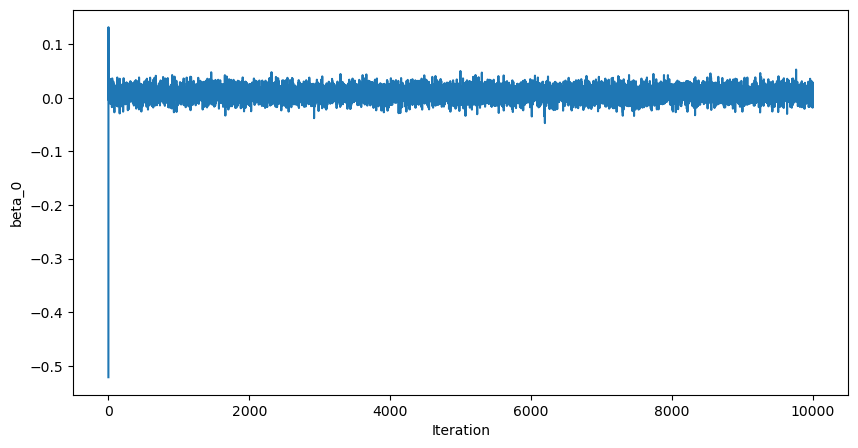

In [14]:
traceplot = trace['beta_0'].plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("beta_0")

Text(0, 0.5, 'beta_1')

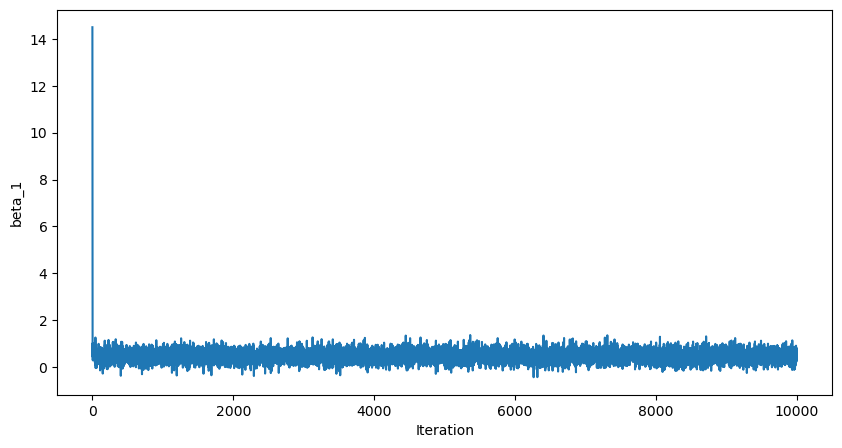

In [15]:
traceplot = trace['beta_1'].plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("beta_1")

Text(0, 0.5, 'tau')

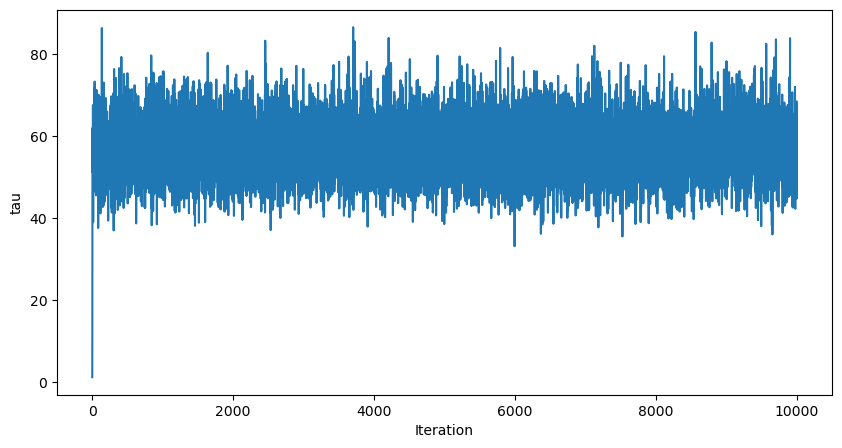

In [16]:
traceplot = trace['tau'].plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("tau")

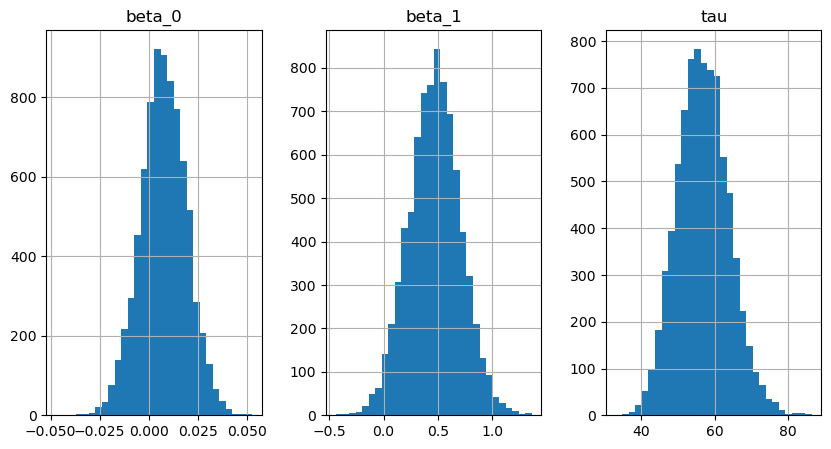

In [19]:
trace_burnt = trace[2000:]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))
#2000번까지의 실행 결과는 초깃값의 영향이 크므로 burn.

In [20]:
print(trace_burnt.median())
print(trace_burnt.std())

beta_0     0.007601
beta_1     0.471398
tau       56.635965
dtype: float64
beta_0    0.011706
beta_1    0.238611
tau       7.000444
dtype: float64
